# Analisis de RNA-seq
¡Requerido activar ambiente miniconda en servidor dedicado *RNAseq*! \
Explora los ambientes disponibles con **conda env list**  

En el *práctico 2* se utilizó el software **fastq_screen** como un primer control de calidad para mapear los reads en formato fastq frente a un conjunto de genomas de referencia y lograr identificar su origen

In [ ]:
# Ejecutar en cluster dedicado
fastq_screen ../../../data/rnaseq_MTWT/*.fastq --outdir ./

Luego se ejecutó **FASTQC** para generar reportes de calidad de los datos de secuenciación para poder indentificar posibles problemas de lectura y contenido. Importante en el preprocesamiento de los datos

In [ ]:
fastqc ../../data/rnaseq_MTWT/*.fastq -o ./

### **Pre-procesamiento de RNA-seq**
Prueba inicial para corte de adaptadores y filtrado de secuencias utilizando CutAdapt 5.1 con Python 3.10.18 siguiendo la siguiente línea de comandos.\
> **Nota:**\
> La lista de adaptadores y de posibles contaminantes fue obtenida de \
> https://support-docs.illumina.com/SHARE/AdapterSequences/Content/SHARE/AdapterSeq/Nextera/SequencesNextera_Illumina.htm

In [ ]:
# Ejecución de la linea de comandos sobre ambiente miniconda con los programas respectivos instalados

cutadapt -a CTGTCTCTTATACACATCT -A CTGTCTCTTATACACATCT --action trim -u -2 -U -2 \
-q 30 -Q 30 --poly-a --trim-n --pair-filter=any --minimum-length 50 \
-o WT1_R1_out.fastq -p WT1_R2_out.fastq ../../data/rnaseq_MTWT/WT1_Pax6_R1_subset.fastq ../../data/rnaseq_MTWT/WT1_Pax6_R2_subset.fastq > reportWT1.txt

Siempre ejecutar **FastQC** para verificar la calidad del filtrado y modificaciones de los reads

In [ ]:
fastqc *.fastq -o quality_ctrl/

### **Alineamiento de secuencias**

**¿Qué es un archivo GTF?**
El **GTF (Gene Transfer Format)** es un archivo de texto tabulado utilizado para almacenar **anotaciones genómicas** como genes, transcritos, exones, CDS y UTRs.  
Es una variante estandarizada de **GFF2**, diseñada específicamente para representar estructuras génicas y transcriptómicas.

---
#### **Estructura del archivo**

Cada línea (excepto comentarios que comienzan con `#`) contiene **9 columnas obligatorias**:

1. **seqname** → Cromosoma/contig (ej. `chr1`, `MT`).  
2. **source** → Fuente de la anotación (ej. `ENSEMBL`, `HAVANA`).  
3. **feature** → Tipo de elemento (`gene`, `transcript`, `exon`, `CDS`, etc.).  
4. **start** → Posición inicial (*1-based, inclusive*).  
5. **end** → Posición final (*1-based, inclusive*).  
6. **score** → Valor numérico o `.` si no aplica.  
7. **strand** → Hebra (`+`, `-`, o `.`).  
8. **frame** → Fase de codón (`0`, `1`, `2`, o `.`).  
9. **attributes** → Pares clave-valor con metadatos.
---
#### **Ejemplo**

```txt
chr19    HAVANA    exon    409006    409170    .    -    .    gene_id "ENSG00000183186.7"; transcript_id "ENST00000332235.7"; exon_number 1; gene_name "C2CD4C";

In [ ]:
#! /bin/bash
# Script para automatización del alineamiento utilziando HiSat2
source ~/miniconda3/etc/profile.d/conda.sh 
conda activate samtools

# Bucle infinito: se ejecuta hasta que el usuario decida salir con 'exit'
while true; do

    # Solicitar Identificador 1 (ej: WT1, WT2)
    read -p "Introduce el Identificador 1 (ID1, ej: WT1/MUT1): " ID1

    # --- 2. CONDICIÓN DE SALIDA ---
    # Si ambos inputs es 'exit', el script termina.
    if [[ "$ID1" == "exit" ]]; then
        echo "--------------------------------------------------------"
        echo "¡Proceso terminado por el usuario. Saliendo del script!"
        echo "--------------------------------------------------------"
        break
    fi

    # --- 3. EJECUCIÓN DEL COMANDO CUTADAPT ---
    echo "--------------------------------------------------------"
    echo "Ejecutando Hisat2 con ID1: $ID1 ..."

    hisat2 -x "../../data/Danio_rerio_114/Danio_rerio.GRCz11.dna.toplevel" -1 "../preprocess_seq/${ID1}_R1_out.fastq" \
    -2 "../preprocess_seq/${ID1}_R2_out.fastq" -S "mapped_${ID1}.sam" -q \
    --known-splicesite-infile "../../data/Danio_rerio_114/Danio_rerio.GRCz11.114.ss" &> "report${ID1}.txt"
    # Notificar al usuario el estado de la ejecución
    if [ $? -eq 0 ]; then
        echo "Comando ejecutado exitosamente."
        echo "Reporte generado: report${ID1}.txt"
    else
        echo "¡ERROR! El comando cutadapt falló en esta iteración."
    fi
    echo "--------------------------------------------------------"
done

conda deactivate

Los archivos .sam generados en el alineamiento inicialmente fueron convertidos a archivos .bam en el caso de que se necesitara.\
Se ordenó el mapeo realizado anteriormente con HiSat2 y se generó el reporte del alineamiento utilizando flagstat


In [ ]:
#! /bin/bash

# Conda environment activation
source ~/miniconda3/etc/profile.d/conda.sh 
conda activate samtools

# Sorting and report generation from alignment files
conditions=("WT1" "WT2" "WT3" "MUT1" "MUT2" "MUT3")
base_route="/home/gbernal/run/alignment"

# Files creations
mkdir -p sorted stats

echo "--- Ejecución de conversion inicial ---"

for condition in "${conditions[@]}"; do
    samtools sort "${base_route}/mapped_${condition}.sam" -o "sorted/mapped_sort_${condition}.bam"
    samtools flagstat "sorted/mapped_sort_${condition}.bam" > "stats/report${condition}.txt"

    echo "--- Comando finalizado para ${condition} ---"

done

conda deactivate


Generar gráficos para comunicar reportes de alineamiento generados


Resumen extraído de los reportes:
           Total_reads  Mapped_reads  Mapped_percent  Properly_paired  \
Condition                                                               
WT1          1962365.0     1760945.0           89.74        1411052.0   
WT2          1911337.0     1730273.0           90.53        1347734.0   
WT3          1897991.0     1720690.0           90.66        1337154.0   
MUT1         2104835.0     1924837.0           91.45        1359544.0   
MUT2         2014068.0     1837227.0           91.22        1321234.0   
MUT3         2016596.0     1824529.0           90.48        1438780.0   

           Properly_paired_percent  Singletons  Singletons_percent  
Condition                                                           
WT1                          83.82     52680.0                3.13  
WT2                          84.35     49062.0                3.07  
WT3                          84.85     42971.0                2.73  
MUT1                         84.52 

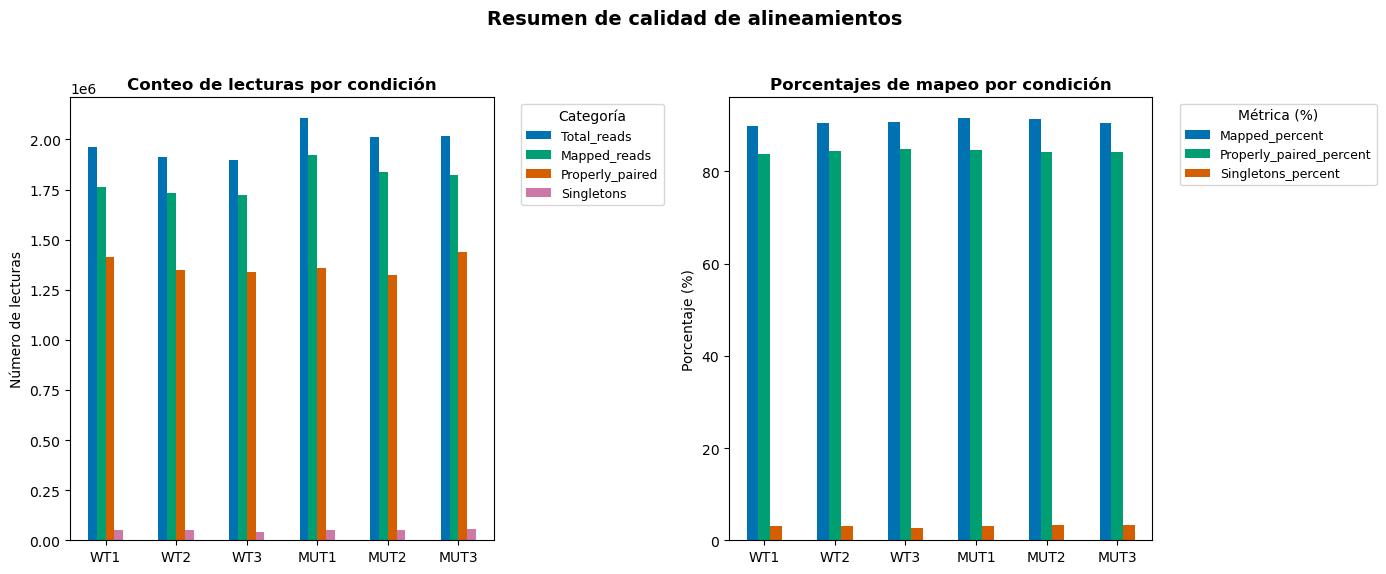

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuración ---
stats_dir = "../run/alignment/stats"
conditions = ["WT1", "WT2", "WT3", "MUT1", "MUT2", "MUT3"]

# --- Función para extraer métricas desde cada archivo ---
def parse_flagstat(file_path):
    data = {
        "Total_reads": 0,
        "Mapped_reads": 0,
        "Mapped_percent": 0.0,
        "Properly_paired": 0,
        "Properly_paired_percent": 0.0,
        "Singletons": 0,
        "Singletons_percent": 0.0
    }

    with open(file_path, "r") as f:
        for line in f:
            if "in total" in line:
                data["Total_reads"] = int(line.split("+")[0].strip())
            elif "mapped (" in line and "primary mapped" not in line:
                match = re.search(r"(\d+) \+ \d+ mapped \(([\d\.]+)%", line)
                if match:
                    data["Mapped_reads"] = int(match.group(1))
                    data["Mapped_percent"] = float(match.group(2))
            elif "properly paired" in line:
                match = re.search(r"(\d+) \+ \d+ properly paired \(([\d\.]+)%", line)
                if match:
                    data["Properly_paired"] = int(match.group(1))
                    data["Properly_paired_percent"] = float(match.group(2))
            elif "singletons" in line:
                match = re.search(r"(\d+) \+ \d+ singletons \(([\d\.]+)%", line)
                if match:
                    data["Singletons"] = int(match.group(1))
                    data["Singletons_percent"] = float(match.group(2))
    return data

# --- Procesar todos los reportes ---
results = {}
for cond in conditions:
    report_path = os.path.join(stats_dir, f"report{cond}.txt")
    if os.path.exists(report_path):
        results[cond] = parse_flagstat(report_path)
    else:
        print(f" No se encontró {report_path}")

# --- Crear DataFrame ---
df = pd.DataFrame(results).T
df.index.name = "Condition"

print("\nResumen extraído de los reportes:")
print(df)

# --- Crear figura con dos subplots ---
plt.style.use("seaborn-v0_8-colorblind")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Panel 1: conteos absolutos ---
df[["Total_reads", "Mapped_reads", "Properly_paired", "Singletons"]].plot(kind="bar", ax=axes[0])
axes[0].set_title("Conteo de lecturas por condición", fontsize=12, weight="bold")
axes[0].set_ylabel("Número de lecturas")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title="Categoría", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)

# --- Panel 2: porcentajes ---
df[["Mapped_percent", "Properly_paired_percent", "Singletons_percent"]].plot(kind="bar", ax=axes[1])
axes[1].set_title("Porcentajes de mapeo por condición", fontsize=12, weight="bold")
axes[1].set_ylabel("Porcentaje (%)")
axes[1].set_xlabel("")
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title="Métrica (%)", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)

plt.suptitle("Resumen de calidad de alineamientos", fontsize=14, weight="bold")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("alignment_summary_panel.png", dpi=300)
plt.show()


RSeqC - Entrega parámetros de calidad del alineamiento (en este caso se utilizó GeneCoverage)

In [ ]:
# Antes de ejecutar el script para el calculo del gene coverage se ejecutaron los siguientes comandos

conda activate samtools

samtools index mapped_sort_WT1.bam
samtools index mapped_sort_WT2.bam
samtools index mapped_sort_WT3.bam
samtools index mapped_sort_MUT3.bam
samtools index mapped_sort_MUT2.bam
samtools index mapped_sort_MUT1.bam

conda deactivate

In [ ]:
#!/bin/bash

# Lista de las condiciones o tipos de muestra
conditions=("WT1" "WT2" "WT3" "MUT1" "MUT2" "MUT3")

echo "Iniciando el cálculo de cobertura de cuerpo de genes para las muestras: ${conditions[@]}"

# Itera sobre cada elemento de la lista 'conditions'
for condition in "${conditions[@]}"; do
    echo "-> Procesando muestra: ${condition}"
    
    # Ejecuta el comando, sustituyendo ${condition}
    geneBody_coverage.py \
        -i "../sorted/mapped_sort_${condition}.bam", "../sorted/mapped_sort_${condition}.bam", "../sorted/mapped_sort_${condition}.bam",\
        "../sorted/mapped_sort_${condition}.bam", "../sorted/mapped_sort_${condition}.bam", "../sorted/mapped_sort_${condition}.bam" \
        -r "../../../data/Danio_rerio_114/Danio_rerio.GRCz11.114.bed" \
        -o "genecoverage_unified"
    
    # Comprueba el código de salida del comando anterior ($?)
    if [ $? -eq 0 ]; then
        echo "   [OK] Archivo de salida 'genecoverage_${condition}' creado con éxito."
    else
        echo "   [ERROR] Fallo al ejecutar geneBody_coverage.py para ${condition}." >&2
    fi
done

echo "Proceso completado para todas las muestras."

Adicionalmente se realizó un conteo y estimación de genes con HT-seq

In [ ]:
#!/bin/bash

source ~/miniconda3/etc/profile.d/conda.sh 
conda activate htseq-count 

# Lista de las condiciones o tipos de muestra
conditions=("WT1" "WT2" "WT3" "MUT1" "MUT2" "MUT3")

echo "Iniciando el cálculo de estimacion de expresion de genes para las muestras: ${conditions[@]}"

# Itera sobre cada elemento de la lista 'conditions'
for condition in "${conditions[@]}"; do
    output="counts_${condition}.txt"
    echo "-> Procesando muestra: ${condition}"
    
    # Ejecuta el comando, sustituyendo ${condition}
    htseq-count  \
        --stranded="no" --idattr="gene_id" \
        "../sorted/mapped_sort_${condition}.bam" \
        "../../../data/Danio_rerio_114/Danio_rerio.GRCz11.114.gtf" \
	> "${output}"
    
    # Comprueba el código de salida del comando anterior ($?)
    if [ $? -eq 0 ]; then
        echo "   [OK] Archivo de conteo '${output}' creado con éxito."
    else
        echo "   [ERROR] Fallo al ejecutar htseq-count para ${condition}." >&2
    fi
done

echo "Proceso completado para todas las muestras."

conda deactivate 

Generar una tabla resumen del conteo de genes de las condiciones estudiadas

In [6]:
import os
import pandas as pd

# --- Configuración ---
# Ajusta la ruta si los archivos están en otra carpeta
input_dir = "../run/alignment/gene_estimation"
conditions = ["WT1", "WT2", "WT3", "MUT1", "MUT2", "MUT3"]

# --- Función para leer las últimas líneas del archivo ---
def read_summary_counts(file_path):
    summary = {}
    with open(file_path, "r") as f:
        lines = f.readlines()
        tail = lines[-10:]
        for line in tail:
            if line.startswith("__"):
                key, value = line.strip().split("\t")
                summary[key] = int(value)
    return summary

# --- Recolectar resultados ---
results = {}
for cond in conditions:
    filename = f"counts_{cond}.txt"
    path = os.path.join(input_dir, filename)
    if os.path.exists(path):
        results[cond] = read_summary_counts(path)
    else:
        print(f"No se encontró el archivo {filename}")

# --- Crear tabla ---
df = pd.DataFrame(results).T
df.index.name = "Condition"

# --- Guardar como CSV y mostrar ---
output_file = "../run/alignment/gene_estimation/summary_counts_table.csv"
df.to_csv(output_file)

print(f"\n Tabla generada: {output_file}\n")
print(df)



 Tabla generada: ../run/alignment/gene_estimation/summary_counts_table.csv

           __no_feature  __ambiguous  __too_low_aQual  __not_aligned  \
Condition                                                              
WT1              242294        51683            42746          80861   
WT2              244815        59197            38773          72787   
WT3              201382        51315            33055          74148   
MUT1             238532        33361            39936          70992   
MUT2             230856        29286            41333          69328   
MUT3             268800        47667            46567          74087   

           __alignment_not_unique  
Condition                          
WT1                        158859  
WT2                        149512  
WT3                        148947  
MUT1                       203509  
MUT2                       191430  
MUT3                       160029  


Script para la ejecución del análisis de expresión diferencial utilizando R

In [ ]:
setwd('/home/gbernal/run/diffexp')


library( "DESeq2" )
#version 1.6.1

#desig metadata
metadata <- read.delim(file="/home/gbernal/run/diffexp/metadata.txt", header=TRUE)   

#create a count data set readabable by DESeq
ddsHTseq <- DESeqDataSetFromHTSeqCount(metadata, "/home/gbernal/run/alignment/gene_estimation", design=~ Condition)

# define base level: logFC is the expected comparison agains the base level
ddsHTseq$Condition <- relevel(ddsHTseq$Condition, 'Wild-type')

#DE test
ddsHTseq <- DESeq(ddsHTseq)
#to visualized the results od the DE test (note that alpha value is set to 0.1 by default)
res <- results(ddsHTseq, cooksCutoff=FALSE )
write.table(res, file="DEtest.txt")

#order genes by adj p value
resOrdered <- res[order(res$padj), ]
head(resOrdered)
write.table(resOrdered, file="resOrdered.txt")


#obtain the normalized count
Normalized_count <- counts(ddsHTseq, normalized=TRUE)
write.table(Normalized_count, file="Normalized_count.txt")
raw_count <- counts(ddsHTseq, normalized=FALSE)
write.table(raw_count, file="raw_count.txt")
sizeFactors( ddsHTseq )

#summary of the results
summary(res)
#infomation about the columns on results
mcols(res)$description

#visualization by MAplot
pdf(file="plot_MAplot.pdf")
plotMA(resOrdered, main='Wild-type vs Mutant', ylim=c(-15,15))
dev.off()


#extraction transformed data:VSD
vsd <- varianceStabilizingTransformation(ddsHTseq)
vsd_transformation<-assay(vsd)
write.table(vsd_transformation, file="vsd_transformation.txt")

Iniciando Script 1 (Matplotlib): Gráfico de Volcán...
¡Gráfico de Volcán (Matplotlib) guardado como '../run/diffexpvolcano_plot_matplotlib.png'!


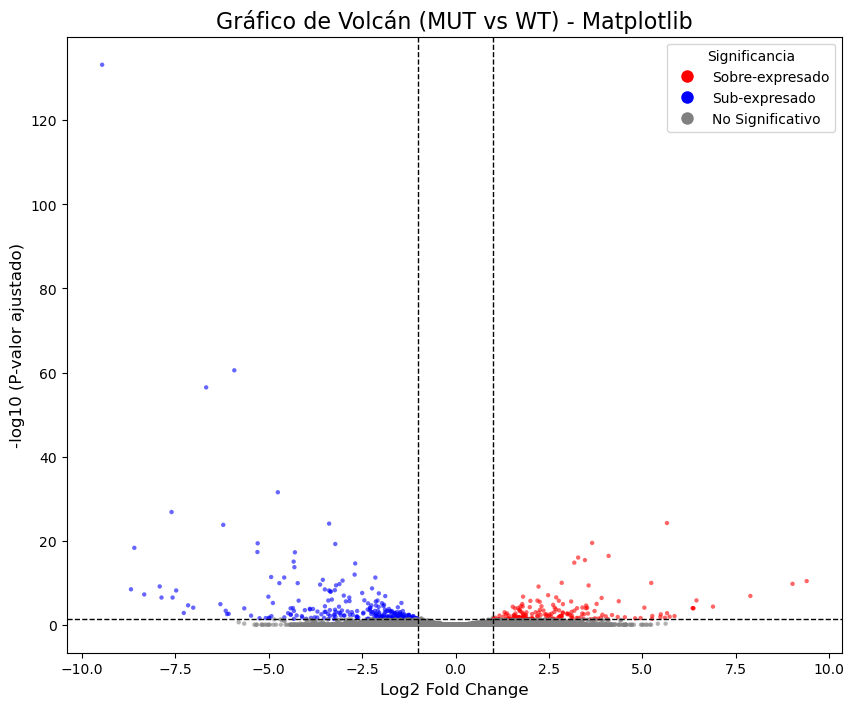

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

print("Iniciando Script 1 (Matplotlib): Gráfico de Volcán...")

# --- 1. Cargar y fusionar datos ---
try:
    df_de = pd.read_excel('../run/diffexp/analisis_completo_fusionado.xlsx')
    df_mart = pd.read_csv('../run/diffexp/mart_export.txt', sep='\t')
except FileNotFoundError:
    print("Error: No se encontraron los archivos de entrada.")
    exit()

df_de['Ensembl_ID'] = df_de['Ensembl_ID'].str.strip('"')
df_full = pd.merge(
    df_de,
    df_mart,
    left_on='Ensembl_ID',
    right_on='Gene stable ID',
    how='left'
)

# --- 2. Preparar datos para el gráfico ---
df_full['padj_clean'] = df_full['padj'].fillna(1.0)
df_full['padj_clean'] = df_full['padj_clean'].replace(0, 1e-300)
df_full['-log10(padj)'] = -np.log10(df_full['padj_clean'])

padj_threshold = 0.05
lfc_threshold = 1.0

def categorize_gene(row):
    if row['padj'] < padj_threshold and row['log2FoldChange'] > lfc_threshold:
        return 'Sobre-expresado'
    elif row['padj'] < padj_threshold and row['log2FoldChange'] < -lfc_threshold:
        return 'Sub-expresado'
    else:
        return 'No Significativo'

df_full['Significancia'] = df_full.apply(categorize_gene, axis=1)

# --- 3. Generar Gráfico de Volcán con Matplotlib ---

# Mapear los colores a cada punto
color_map = {
    'Sobre-expresado': 'red',
    'Sub-expresado': 'blue',
    'No Significativo': 'grey'
}
colors = df_full['Significancia'].map(color_map)

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar todos los puntos a la vez usando la lista de colores
ax.scatter(
    df_full['log2FoldChange'],
    df_full['-log10(padj)'],
    c=colors,
    alpha=0.6,
    s=10, # Tamaño del punto
    edgecolor='none'
)

# Añadir líneas de umbral
ax.axhline(y=-np.log10(padj_threshold), color='black', linestyle='--', linewidth=1)
ax.axvline(x=lfc_threshold, color='black', linestyle='--', linewidth=1)
ax.axvline(x=-lfc_threshold, color='black', linestyle='--', linewidth=1)

# Etiquetas y título
ax.set_title('Gráfico de Volcán (MUT vs WT) - Matplotlib', fontsize=16)
ax.set_xlabel('Log2 Fold Change', fontsize=12)
ax.set_ylabel('-log10 (P-valor ajustado)', fontsize=12)

# --- Crear leyenda manualmente ---
# Creamos "artistas" falsos para la leyenda
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Sobre-expresado',
               markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Sub-expresado',
               markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='No Significativo',
               markerfacecolor='grey', markersize=10)
]
ax.legend(handles=legend_elements, title='Significancia')

# Guardar figura
output_file = '../run/diffexpvolcano_plot_matplotlib.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')

print(f"¡Gráfico de Volcán (Matplotlib) guardado como '{output_file}'!")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Iniciando Script 2 (Matplotlib): Mapa de Calor...")

# --- 1. Cargar y fusionar datos ---
try:
    df_de = pd.read_excel('../run/diffexp/analisis_completo_fusionado.xlsx')
    df_mart = pd.read_csv('../run/diffexp/mart_export.txt', sep='\t')
except FileNotFoundError:
    print("Error: No se encontraron los archivos de entrada.")
    exit()

df_de['Ensembl_ID'] = df_de['Ensembl_ID'].str.strip('"')
df_full = pd.merge(
    df_de,
    df_mart,
    left_on='Ensembl_ID',
    right_on='Gene stable ID',
    how='left'
)

# --- 2. Preparar datos para el Heatmap ---

# Filtrar genes significativos (p.ej., padj < 0.05)
# Y ordenarlos por Log2FC (sustituto del clustering)
df_sig = df_full[df_full['padj'] < 0.05].sort_values('log2FoldChange', ascending=False)

# Rellenar NAs en 'Gene name' con 'Ensembl_ID'
df_sig['Gene_name'] = df_sig['Gene_name'].fillna(df_sig['Ensembl_ID'])

# Seleccionar columnas de conteos
count_columns = ['WT1', 'WT2', 'WT3', 'MUT1', 'MUT2', 'MUT3']
df_heatmap_data = df_sig.set_index('Gene name')[count_columns]
df_heatmap_data = df_heatmap_data.groupby(level=0).mean() # Eliminar duplicados

print(f"Generando heatmap con {df_heatmap_data.shape[0]} genes significativos.")

if df_heatmap_data.empty:
    print("No se encontraron genes significativos para graficar.")
else:
    # --- Escalar Z-score manualmente (por fila/gen) ---
    def scale_rows(row):
        # Asegurar que la desviación estándar no sea cero
        std = row.std(ddof=0)
        if std == 0:
            return row - row.mean() # O simplemente np.zeros_like(row)
        return (row - row.mean()) / std

    scaled_data = df_heatmap_data.apply(scale_rows, axis=1)
    
    # Limitar valores extremos para un mejor color
    scaled_data = scaled_data.clip(-2, 2) 

    # --- 3. Generar Heatmap con Matplotlib ---
    
    fig, ax = plt.subplots(figsize=(8, 12))
    
    cax = ax.imshow(
        scaled_data,
        cmap='vlag',        
        aspect='auto'       
    )
    
    # Añadir barra de color
    fig.colorbar(cax, label='Z-score (Expresión relativa)', orientation='horizontal', pad=0.05)
    
    # Configurar ejes
    ax.set_title('Heatmap Genes Significativos (Ordenado por Log2FC)', fontsize=14)
    ax.set_xlabel('Muestras')
    ax.set_ylabel('Genes Significativos')
    
    # Configurar etiquetas del eje X
    ax.set_xticks(np.arange(len(scaled_data.columns)))
    ax.set_xticklabels(scaled_data.columns, rotation=90)
    
    # ax.set_yticks(np.arange(len(scaled_data.index)))
    # ax.set_yticklabels(scaled_data.index)
    # Para muchos genes, es mejor ocultarlas:
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Guardar figura
    output_file = 'heatmap_matplotlib.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"¡Mapa de Calor (Matplotlib) guardado como '{output_file}'!")

Iniciando Script 2 (Matplotlib): Mapa de Calor...
Generando heatmap con 0 genes significativos.
No se encontraron genes significativos para graficar.


Iniciando Script 3 (Matplotlib): Gráfico de Enriquecimiento Funcional...
¡Gráfico de Enriquecimiento (Matplotlib) guardado como '../run/diffexp/BP_enrichment_plot_matplotlib.png'!


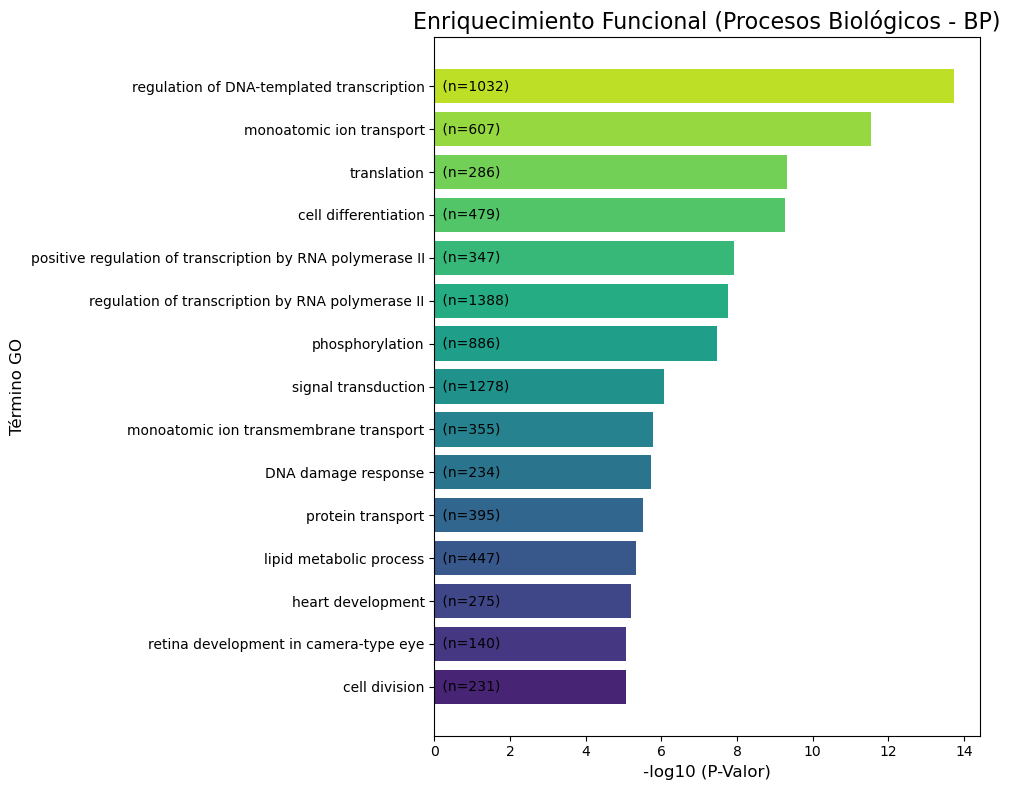

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Para el colormap
import numpy as np

print("Iniciando Script 3 (Matplotlib): Gráfico de Enriquecimiento Funcional...")

# --- 1. Cargar datos de DAVID ---
david_file = '../run/diffexp/BP_DAVIDChartReport_lista_DE_daniorerio_2025-10-30.csv'
plot_title = 'Enriquecimiento Funcional (Procesos Biológicos - BP)'
output_file = '../run/diffexp/BP_enrichment_plot_matplotlib.png'

try:
    df_david = pd.read_csv(david_file)
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{david_file}'")
    exit()

# --- 2. Preparar datos para el gráfico ---
df_plot = df_david.nsmallest(15, 'P-Value').copy()
df_plot['-log10(PValue)'] = -np.log10(df_plot['P-Value'])

df_plot = df_plot.sort_values('-log10(PValue)', ascending=True)

# --- 3. Generar Gráfico de Barras con Matplotlib ---

fig, ax = plt.subplots(figsize=(10, 8))

# Generar colores desde un colormap
colors = cm.viridis(np.linspace(0.1, 0.9, len(df_plot['Term'])))

# Crear el gráfico de barras horizontal
ax.barh(
    df_plot['Term'],
    df_plot['-log10(PValue)'],
    color=colors
)

ax.set_title(plot_title, fontsize=16)
ax.set_xlabel('-log10 (P-Valor)', fontsize=12)
ax.set_ylabel('Término GO', fontsize=12)

# Añadir etiquetas de conteo de genes (iterando sobre los datos ordenados)
for i, row in df_plot.iterrows():
    ax.text(
        0.1, 
        row['Term'], 
        f" (n={row['Count']})", 
        color='black', 
        ha='left', 
        va='center'
    )

plt.tight_layout()

# Guardar figura
plt.savefig(output_file, dpi=300)
print(f"¡Gráfico de Enriquecimiento (Matplotlib) guardado como '{output_file}'!")

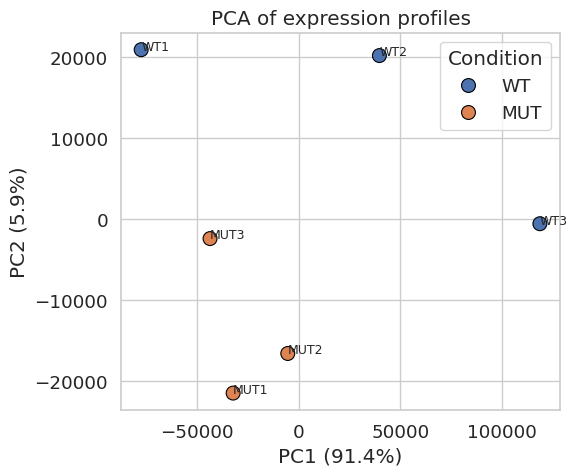

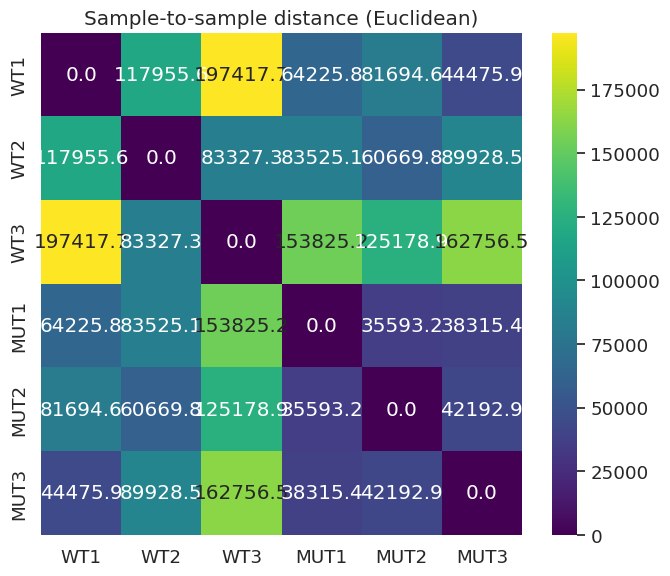

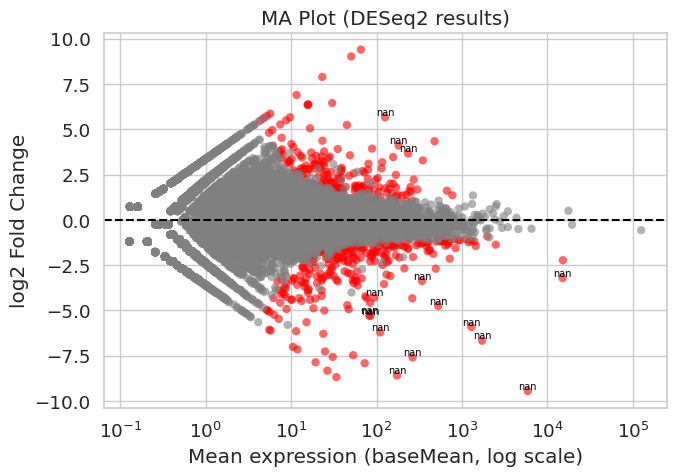

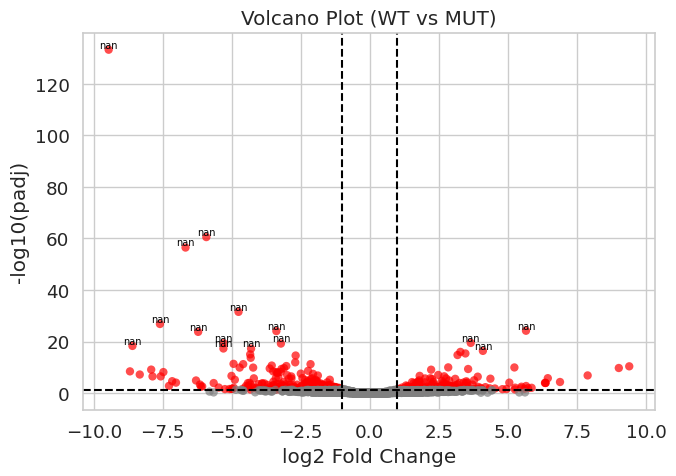

TypeError: "value" parameter must be a scalar, dict or Series, but you passed a "Index"

In [15]:
# ======================================================
# ANALISIS DE EXPRESIÓN DIFERENCIAL 
# Integración con BioMart para nombres de genes
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import os

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['axes.linewidth'] = 1.2

# ------------------- CONFIGURACIÓN -------------------
EXCEL_PATH = "../run/diffexp/analisis_completo_fusionado.xlsx"
BIOMART_PATH = "../run/diffexp/mart_export.txt"
BASE_DIR = "../run/diffexp"
OUT_DIR = os.path.join(BASE_DIR, "figures")
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------- LECTURA DE DATOS -------------------
# 1. Resultados de expresión diferencial
df = pd.read_excel(EXCEL_PATH, sheet_name="Sheet1")
df.columns = df.columns.str.replace('"', '').str.strip()
df["Ensembl_ID"] = df["Ensembl_ID"].str.strip()
df.set_index("Ensembl_ID", inplace=True)

# 2. Nombres de genes desde BioMart
biomart = pd.read_csv(BIOMART_PATH, sep="\t")
biomart.columns = ["Ensembl_ID", "Gene_name"]
biomart["Ensembl_ID"] = biomart["Ensembl_ID"].str.strip()
biomart["Gene_name"] = biomart["Gene_name"].fillna("NA")

# 3. Combinar ambos
df = df.merge(biomart, left_index=True, right_on="Ensembl_ID", how="left").set_index("Ensembl_ID")

# ------------------- MATRIZ DE EXPRESIÓN -------------------
samples = ["WT1", "WT2", "WT3", "MUT1", "MUT2", "MUT3"]
expr = df[samples].apply(pd.to_numeric, errors="coerce").fillna(0)
meta = pd.DataFrame({"SampleName": samples, "Condition": ["WT"]*3 + ["MUT"]*3})

# ------------------- PCA -------------------
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expr.T)
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["Condition"] = meta["Condition"]
pca_df["Sample"] = meta["SampleName"]
expl_var = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(6,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Condition", s=100, edgecolor="black")
for i, r in pca_df.iterrows():
    plt.text(r["PC1"]+0.2, r["PC2"], r["Sample"], fontsize=9)
plt.xlabel(f"PC1 ({expl_var[0]:.1f}%)")
plt.ylabel(f"PC2 ({expl_var[1]:.1f}%)")
plt.title("PCA of expression profiles")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/PCA_expression.png", dpi=300)
plt.show()

# ------------------- HEATMAP DISTANCIAS -------------------
dist = squareform(pdist(expr.T, metric="euclidean"))
dist_df = pd.DataFrame(dist, index=expr.columns, columns=expr.columns)
plt.figure(figsize=(7,6))
sns.heatmap(dist_df, cmap="viridis", annot=True, fmt=".1f")
plt.title("Sample-to-sample distance (Euclidean)")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/SampleDistanceHeatmap.png", dpi=300)
plt.show()

# ------------------- MA PLOT CON NOMBRES -------------------
alpha = 0.05
df["signif"] = df["padj"] < alpha
top_ma = df[df["signif"]].sort_values("padj").head(15)

plt.figure(figsize=(7,5))
plt.scatter(df["baseMean"], df["log2FoldChange"],
            c=df["signif"].map({True:"red", False:"gray"}), alpha=0.6, edgecolor="none")
plt.xscale("log")
plt.xlabel("Mean expression (baseMean, log scale)")
plt.ylabel("log2 Fold Change")
plt.title("MA Plot (DESeq2 results)")
plt.axhline(0, color="black", linestyle="--")

for _, r in top_ma.iterrows():
    plt.text(r["baseMean"], r["log2FoldChange"], str(r["Gene_name"]),
             fontsize=7, ha='center', va='bottom', color='black')

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/MA_plot_labeled.png", dpi=300)
plt.show()

# ------------------- VOLCANO PLOT CON NOMBRES -------------------
lfc_thr = 1.0
df["neglog10padj"] = -np.log10(df["padj"])
sig = (df["padj"] < alpha) & (abs(df["log2FoldChange"]) >= lfc_thr)

plt.figure(figsize=(7,5))
plt.scatter(df["log2FoldChange"], df["neglog10padj"],
            c=sig.map({True:"red", False:"gray"}), alpha=0.7, edgecolor="none")
plt.axvline(x=lfc_thr, color="black", ls="--")
plt.axvline(x=-lfc_thr, color="black", ls="--")
plt.axhline(y=-np.log10(alpha), color="black", ls="--")
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10(padj)")
plt.title("Volcano Plot (WT vs MUT)")

top_volc = df[sig].sort_values("padj").head(15)
for _, r in top_volc.iterrows():
    plt.text(r["log2FoldChange"], r["neglog10padj"], str(r["Gene_name"]),
             fontsize=7, ha='center', va='bottom', color='black')

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/Volcano_plot_labeled.png", dpi=300)
plt.show()

# ------------------- HEATMAP TOP 50 -------------------
top = df.nsmallest(50, "padj")
z = (expr.loc[top.index] - expr.loc[top.index].mean(axis=1).values[:,None]) / expr.loc[top.index].std(axis=1).values[:,None]
row_labels = top["Gene_name"].fillna(top.index)

plt.figure(figsize=(6,10))
sns.heatmap(z, cmap="vlag", yticklabels=row_labels, cbar_kws={'label': 'Z-score'})
plt.title("Top 50 DE genes (z-score of expression)")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/TopGenes_Heatmap_labeled.png", dpi=300)
plt.show()

print(f"✅ Figuras generadas y guardadas en: {OUT_DIR}")
